<a href="https://colab.research.google.com/github/DiegoLeonG96/Tarea3_MLA/blob/main/Tarea_3_MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Profesor: Tomás Fontecilla</em><br>

</div>

# **Machine Learning Avanzado: Tarea N°3**
*17 de diciembre de 2024*

Integrantes:

- Julio Assmann
- Diego León
- Sofía Vits

## Introducción

# Objetivos

## Metodología

In [1]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.3 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from keras import models, layers, optimizers, regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import random
import kagglehub
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as adfuller
import ruptures as rpt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.callbacks import EarlyStopping
# Establecer la semilla para Python
random.seed(42)

# Establecer la semilla para NumPy
np.random.seed(42)

# Establecer la semilla para TensorFlow
tf.random.set_seed(42)

## Modelos

### Autoencoder

#### Carga de datos

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving denoising-dirty-documents.zip to denoising-dirty-documents.zip


In [ ]:
!unzip denoising-dirty-documents.zip
!unzip train.zip
!unzip train_cleaned.zip
!unzip test.zip

Archive:  denoising-dirty-documents.zip
  inflating: sampleSubmission.csv.zip  
  inflating: test.zip                
  inflating: train.zip               
  inflating: train_cleaned.zip       
Archive:  train.zip
   creating: train/
  inflating: train/101.png           
  inflating: train/102.png           
  inflating: train/104.png           
  inflating: train/105.png           
 extracting: train/107.png           
 extracting: train/108.png           
 extracting: train/11.png            
  inflating: train/110.png           
 extracting: train/111.png           
  inflating: train/113.png           
  inflating: train/114.png           
 extracting: train/116.png           
  inflating: train/117.png           
 extracting: train/119.png           
 extracting: train/12.png            
 extracting: train/120.png           
  inflating: train/122.png           
 extracting: train/123.png           
  inflating: train/125.png           
  inflating: train/126.png           
  infl

In [ ]:
!ls

denoising-dirty-documents.zip  sampleSubmission.csv.zip  test.zip  train_cleaned      train.zip
sample_data		       test			 train	   train_cleaned.zip


In [ ]:
import cv2
import os
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #escala de grises
    img = img/255.0 # normalizar
    img = np.reshape(img, (420, 540, 1))

    return img

X_train = []
y_train = []
X_test = []

# train
for f in sorted(os.listdir('train/')):
    X_train.append(process_image('train/' + f))

# target (limpias)
for f in sorted(os.listdir('train_cleaned/')):
    y_train.append(process_image('train_cleaned/' + f))

# test
for f in sorted(os.listdir('test/')):
    X_test.append(process_image('test/' + f))

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)

#### Exploración de datos

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (144, 420, 540, 1)
X_test shape: (72, 420, 540, 1)


Función para mostrar imágenes de ejemplo

In [ ]:
def plot_images_in_grid(images, titles, n_examples=10, n_rows=2, figsize=(15, 5)):
    """
    Generaliza la creación de una grilla para mostrar imágenes.

    Parameters:
    - images: Lista de imágenes a mostrar.
    - titles: Lista de títulos para cada imagen.
    - n_examples: Número máximo de ejemplos a mostrar.
    - n_rows: Número de filas en la grilla.
    - figsize: Tamaño de la figura (tupla).
    """
    n_cols = (n_examples + n_rows - 1) // n_rows
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Convertir ax a una lista, incluso si es un único objeto
    if n_rows == 1 or n_cols == 1:
        ax = np.array(ax).flatten()
    else:
        ax = ax.flatten()

    for idx in range(len(ax)):
        if idx < n_examples and idx < len(images):
            ax[idx].imshow(images[idx], cmap = 'gray')
            ax[idx].set_title(titles[idx])
            ax[idx].axis('off')
        else:
            ax[idx].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()


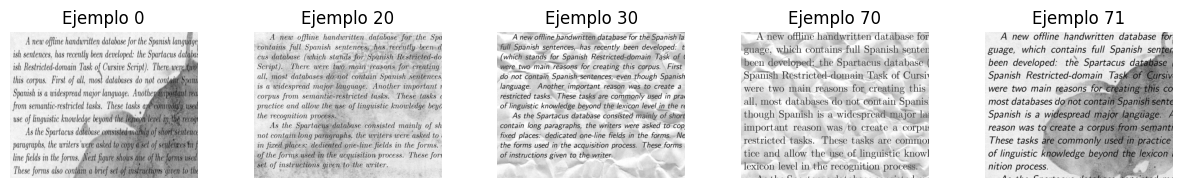

In [ ]:
example_idx = [0, 20, 30, 70, 71]
filtered_images = [X_test[img_idx]/255 for img_idx in example_idx]
filtered_titles = [f'Ejemplo {img_idx}' for img_idx in example_idx]

plot_images_in_grid(filtered_images, filtered_titles, n_examples=len(filtered_images), n_rows=1)

Se pueden ver imágenes con manchas excesivas (ejemplo 0 y 71), manchas
tenues (ejemplo 20) e imágenes arrugadas (30 y 70)

#### Modelo autoencoder y entrenamiento

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42)

In [ ]:
from keras import backend as K
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

primer modelo, 2 capas convolucionales, sin batch normalization ni max pooling. Capas con 32 y 64 filtros

In [ ]:
class ConvAutoEncoder1(Model):
    def __init__(self, input_shape):
        super().__init__()

        # Encoder
        self.encoder = Sequential([
            Input(shape=input_shape),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),
        ])

        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

Se usan 50 épocas base, puede parar con early stopping y en el caso
que no alcance a converger hay que aumentarlo

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.0782 - mse: 0.2231 - val_loss: 0.0755 - val_mse: 0.2151
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - loss: 0.0740 - mse: 0.2118 - val_loss: 0.0709 - val_mse: 0.2025
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 0.0690 - mse: 0.1982 - val_loss: 0.0651 - val_mse: 0.1863
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 0.0627 - mse: 0.1805 - val_loss: 0.0569 - val_mse: 0.1629
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - loss: 0.0537 - mse: 0.1544 - val_loss: 0.0465 - val_mse: 0.1311
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 0.0430 - mse: 0.1214 - val_loss: 0.0366 - val_mse: 0.0982
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - loss: 0.0338 - mse: 0.0899 - val_loss: 0.0307 - val_mse: 0.0757
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - loss: 0.0289 - mse: 0.0706 - val_loss: 0.0290 - val_mse: 0.0671
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - loss: 0.0277 - mse: 0.

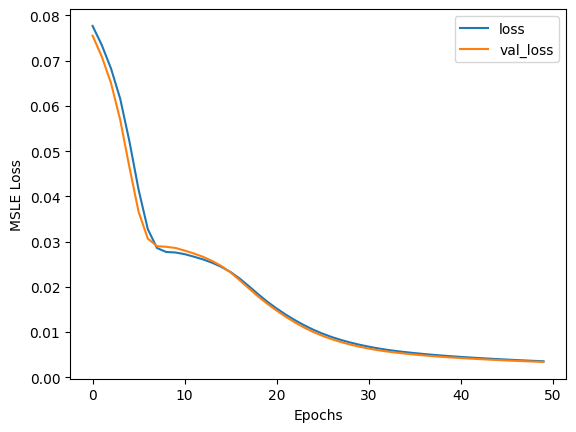

In [ ]:
image_size=(420, 540)
model = ConvAutoEncoder1(input_shape = (image_size[0], image_size[1], 1))
# configurations of model
lr = 1e-4
model.compile(loss='msle', metrics =['mse'], optimizer = optimizers.Adam(learning_rate=lr))
callback = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

No se observa overfitting y se observa convergencia en las funciones de pérdida

Segundo modelo duplicando los números de filtros en capas convolucionales

In [ ]:
class ConvAutoEncoder2(Model):
    def __init__(self, input_shape):
        super().__init__()

        # Encoder
        self.encoder = Sequential([
            Input(shape=input_shape),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),
        ])

        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step - loss: 0.0738 - mse: 0.2109 - val_loss: 0.0568 - val_mse: 0.1622
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 628ms/step - loss: 0.0514 - mse: 0.1470 - val_loss: 0.0389 - val_mse: 0.1058
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - loss: 0.0349 - mse: 0.0934 - val_loss: 0.0300 - val_mse: 0.0718
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 630ms/step - loss: 0.0284 - mse: 0.0672 - val_loss: 0.0297 - val_mse: 0.0670
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 617ms/step - loss: 0.0285 - mse: 0.0647 - val_loss: 0.0301 - val_mse: 0.0674
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step - loss: 0.0287 - mse: 0.0648 - val_loss: 0.0295 - val_mse: 0.0663
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 616ms/step - loss: 0.0280 - mse: 0.0636 - val_loss: 0.0288 - val_mse: 0.0657
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - loss: 0.0275 - mse: 0.0637 - val_loss: 0.0285 - val_mse: 0.0664
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 635ms/step - loss: 0.0272 - mse: 0

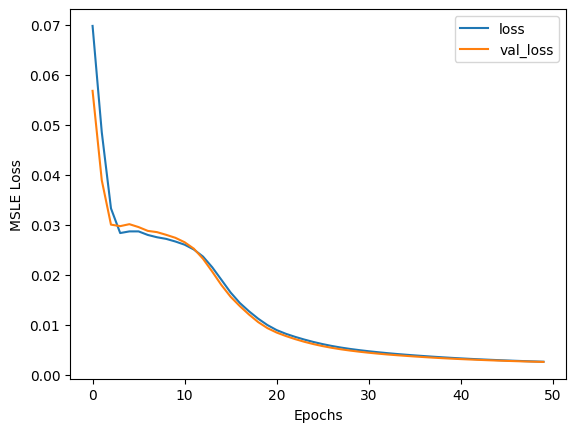

In [ ]:
image_size=(420, 540)
model = ConvAutoEncoder2(input_shape = (image_size[0], image_size[1], 1))
# configurations of model
lr = 1e-4
model.compile(loss='msle', metrics =['mse'], optimizer = optimizers.Adam(learning_rate=lr))
callback = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

Se observa una convergencia similar, pero el mse final en val es menor que el primer modelo, por lo cual es preferible

Tercer modelo. Se añade batch normalization y dropout

In [ ]:
class ConvAutoEncoder3(Model):
    def __init__(self, input_shape):
        super().__init__()

        # Encoder
        self.encoder = Sequential([
            Input(shape=input_shape),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same'),
            Dropout(0.5)
        ])

        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),
            Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 96s 8s/step - loss: 0.0720 - mse: 0.2064 - val_loss: 0.0626 - val_mse: 0.1782
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 667ms/step - loss: 0.0565 - mse: 0.1624 - val_loss: 0.0438 - val_mse: 0.1205
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 678ms/step - loss: 0.0374 - mse: 0.1020 - val_loss: 0.0315 - val_mse: 0.0742
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 678ms/step - loss: 0.0284 - mse: 0.0668 - val_loss: 0.0318 - val_mse: 0.0710
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 689ms/step - loss: 0.0288 - mse: 0.0653 - val_loss: 0.0314 - val_mse: 0.0697
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 679ms/step - loss: 0.0280 - mse: 0.0633 - val_loss: 0.0295 - val_mse: 0.0666
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 682ms/step - loss: 0.0266 - mse: 0.0617 - val_loss: 0.0284 - val_mse: 0.0661
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 700ms/step - loss: 0.0255 - mse: 0.0600 - val_loss: 0.0267 - val_mse: 0.0600
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 657ms/step - loss: 0.0238 - m

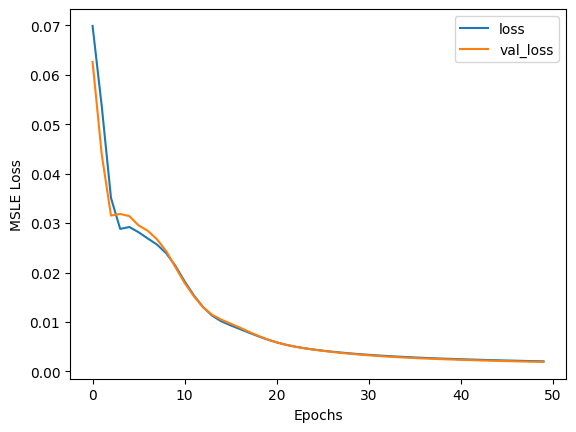

In [ ]:
image_size=(420, 540)
model = ConvAutoEncoder3(input_shape = (image_size[0], image_size[1], 1))
# configurations of model
lr = 1e-4
model.compile(loss='msle', metrics =['mse'], optimizer = optimizers.Adam(learning_rate=lr))
callback = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

Se observa un error aún menor en validación, por lo cual se desprende como la mejor configuración de autoencoder

Ejemplos de salida en el conjunto de test

In [ ]:
example_idx = [0, 20, 30, 70, 71]
image_size=(420, 540)
filtered_images = [X_test[img_idx] for img_idx in example_idx]
filtered_titles = [f'Ejemplo {img_idx}' for img_idx in example_idx]
filtered_images_preds = [model.predict(X_test[img_idx, :, :, :].reshape((1, image_size[0], image_size[1], 1))) for img_idx in example_idx]
filtered_images_preds = [img[0, :, :, :] for img in filtered_images_preds]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Imágenes con ruido

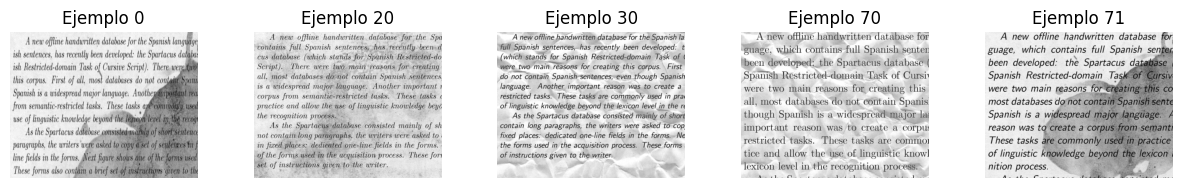

In [ ]:
plot_images_in_grid(filtered_images, filtered_titles, n_examples=len(filtered_images), n_rows=1)

Imágenes limpias con autoencoder

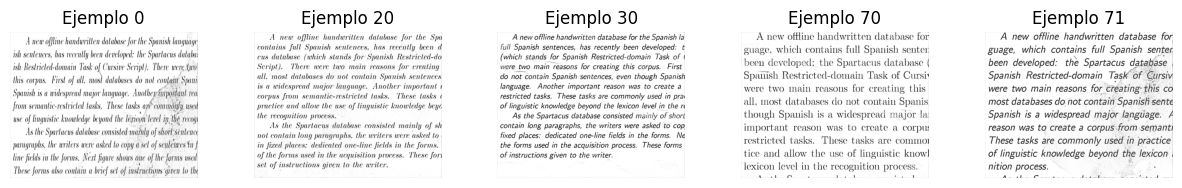

In [ ]:
plot_images_in_grid(filtered_images_preds, filtered_titles, n_examples=len(filtered_images), n_rows=1)

Ejemplo con imagen propia

In [ ]:
example_image  = process_image("ejemplo_sintetico.jpg")
example_image_pred = model.predict(example_image.reshape((1, image_size[0], image_size[1], 1)))

(-0.5, 539.5, 419.5, -0.5)

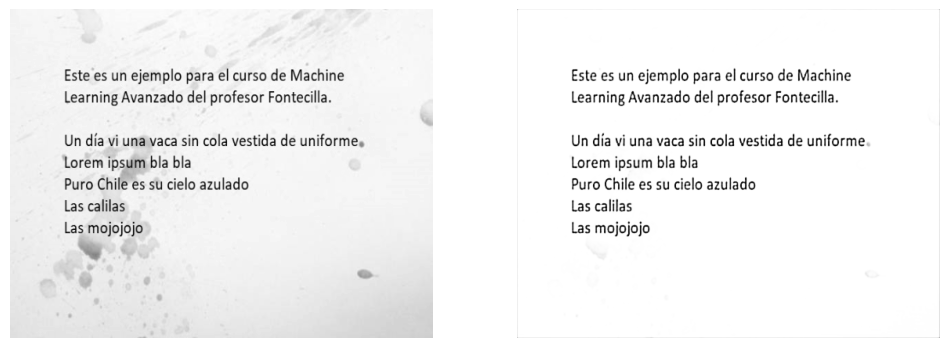

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].imshow(example_image, cmap = 'gray')
ax[1].imshow(example_image_pred[0, :, :, :], cmap = 'gray')
ax[0].axis('off')
ax[1].axis('off')

Se puede ver que en este caso, se logra limpiar correctamente las manchas impuestas en la imagen completamente

### LSTM

### Análisis producción de leche entre los años 1962 y 1975

In [ ]:
df_leche = pd.read_csv('monthly_milk_production.csv')

In [ ]:
df_leche.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [ ]:
df_leche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [ ]:
df_leche.shape

(168, 2)

In [ ]:
df_leche.isnull().sum()

,0
Date,0
Production,0


In [ ]:
df_leche.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


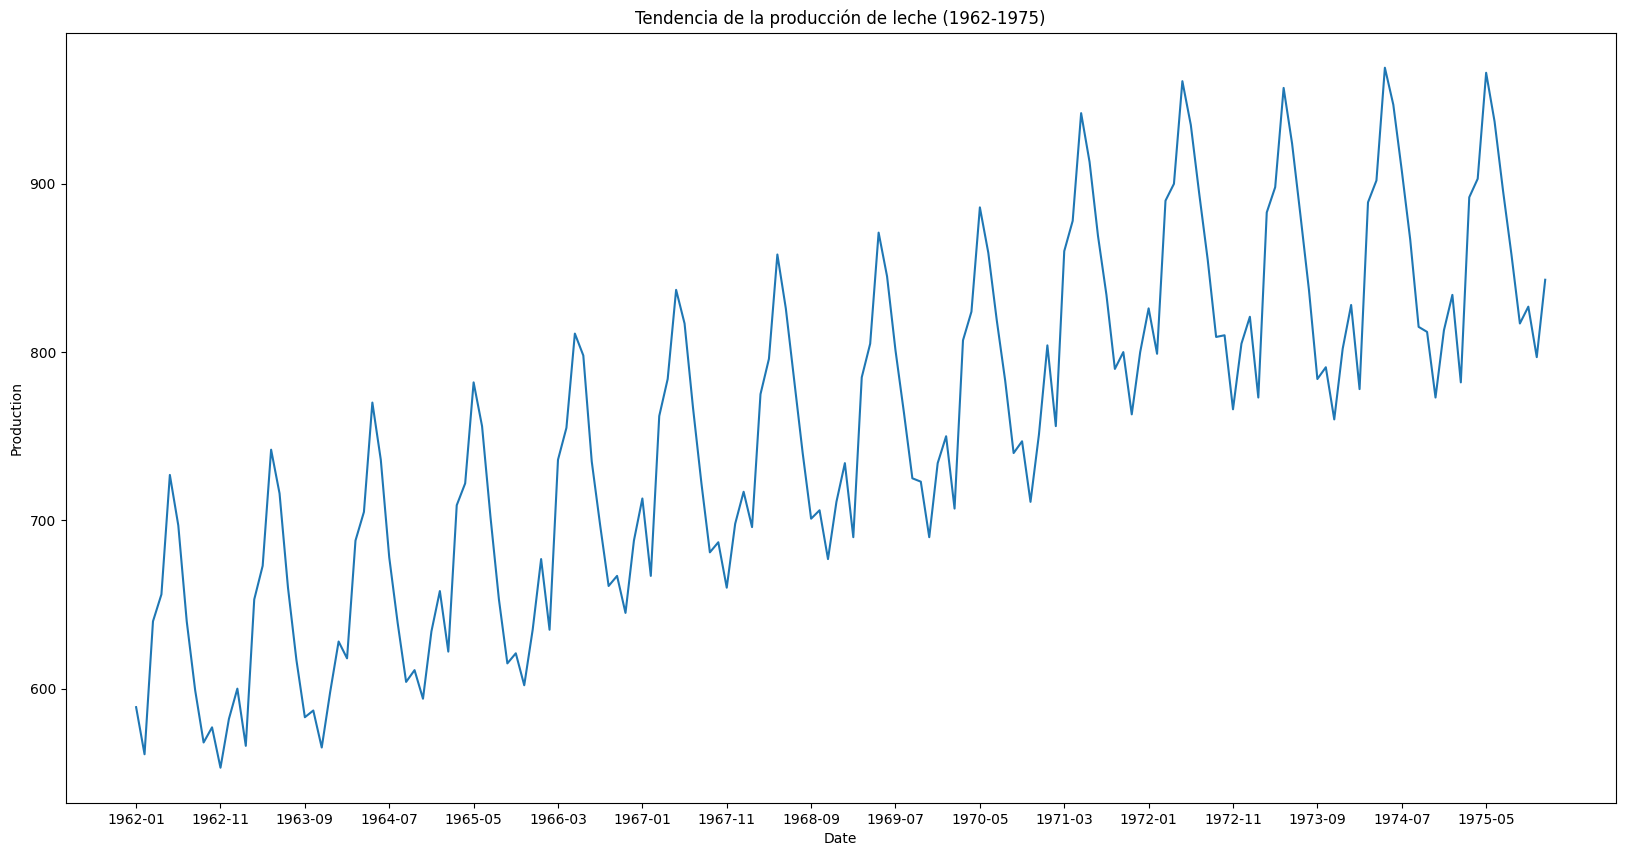

In [ ]:
# Análisis temporal: Cambios de "Production" a lo largo del tiempo
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=df_leche, x='Date', y='Production')
plt.title('Tendencia de la producción de leche (1962-1975)')
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

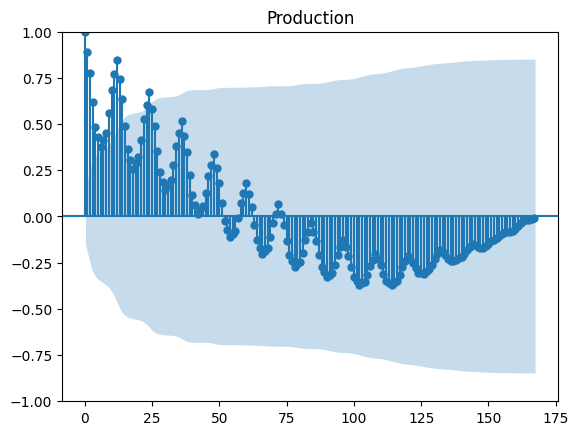

In [ ]:
# Autocorrelation
plot_acf(df_leche['Production'], lags=167, title='Production', alpha = 0.05)
plt.show()

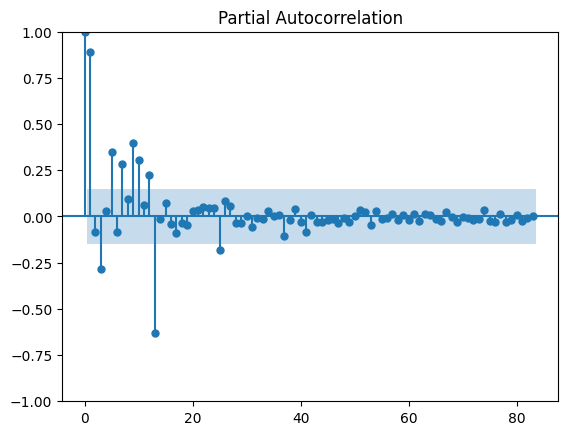

In [ ]:
# Partial Autocorrelation
plot_pacf(df_leche['Production'], lags=83)
plt.show()

**Estacionariedad:**

Corresponde a una propiedad clave en el análisis de series temporales. Una serie temporal se considera `estacionaria`si sus propiedades estadísticas, como la media y la varianza, son constantes en el tiempo. En términos prácticos, una serie estacionaria no tiene tendencia ni estacionalidad, y cualquier cambios observado en la serie es puramente ruido aleatorio.

Para verificar si una serie temporal es estacionaria o no, una de las pruebas más utilizadas es la Prueba de **Dickey-Fuller Aumentada (ADF)**.

Esta prueba tiene las siguientes hipótesis:

**Hipótesis nula (H₀):** La serie tiene una raíz unitaria (es decir, la serie no es estacionaria).

**Hipótesis alternativa (H₁):** La serie es estacionaria.

Si el valor `p` de la prueba es menor a un nivel de significancia, como `0.05`, se rechaza la hipótesis nula y podemos concluir que la serie es estacionaria.

In [ ]:
adf_result = sts.adfuller(df_leche['Production'])

# Extraer los resultados claves
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# Mostrar los resultados de la prueba ADF
adf_statistic, p_value, critical_values

(-1.3038115874221308,
 0.6274267086030311,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677})

Los resultados de la prueba de **Dickey-Fuller Aumentada (ADF)** para la variable **Production** son los siguientes:

- **Estadístico ADF:** resultado -1.30, cuanto más negativo sea este valor más probable es que la serie sea estacionaria. Si el estadístico ADF es menor (más negativo) que los valores críticos, se puede rechazar la hipótesis nula y concluir que la serie es estacionaria. En este caso, el valor de -1.30 no es lo suficientemente negativo para superar los valores críticos, lo que sugiere que la serie no es estacionaria.

- **Valor p:** resultado 0.63, esto significa que al ser mayor que el nivel de significancia comúnmente utilizado (0.05, o 5%), no se podría rechazar la hipótesis nula donde se establece que la serie tiene una raíz unitaria. Esto quiere decir, que la prueba sugiere que la serie `no es estacionaria`.

- **Valores críticos:**

    1% -> -3.47 El 1% respresenta un valor crítico muy conservador, lo cual quiere decir que si el estadístico ADF es menor que este valor, hay evidencia muy fuerte que la serie es estacionaria.

    5% -> -2.88 El 5% es un valor conmúnmente utilizado. Si el estadístico ADF es menor que este valor, podemos concluir que la serie es estacionaria.

    10% -> -2.58 El 10% es el valor máximo. En este caso, si el estadístico ADF es menor que este valor, la serie es estacionaria, pero menos convincente.


**En conclusión, gracias a los valores obtenidos mediante la prueba ADF, podemos indicar que la variable Production no presenta estacionariedad**

Puntos de quiebre detectados: [50, 110, 168]


<Figure size 1000x600 with 0 Axes>

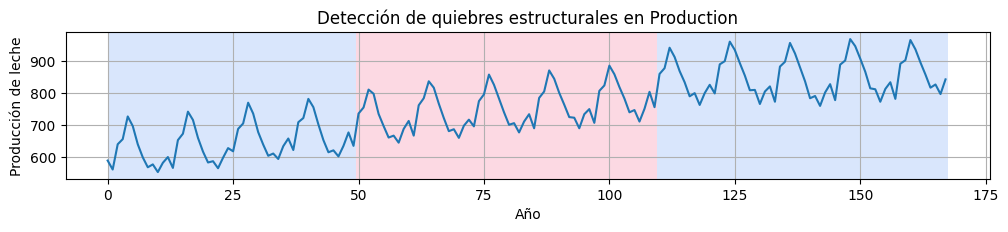

In [ ]:
# Convertir los datos a formato de numpy para aplicar la detección de quiebres
signal = df_leche['Production'].values

# Crear un modelo para detectar quiebres (usando el método de cambios de media)
algo = rpt.Pelt(model="rbf").fit(signal)

# Definir un valor para penalización (esto determina la sensibilidad para detectar quiebres)
pen = 10

# Identificar quiebres
breakpoints = algo.predict(pen=pen)

# Mostrar los puntos donde se detectaron quiebres
print("Puntos de quiebre detectados:", breakpoints)

# Visualizar los quiebres detectados
plt.figure(figsize=(10, 6))
rpt.display(signal, breakpoints)
plt.title('Detección de quiebres estructurales en Production')
plt.xlabel('Año')
plt.ylabel('Producción de leche')
plt.grid(True)
plt.show()

In [ ]:
df_leche["Date"] = df_leche['Date'].str.replace('-', '')

In [ ]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(split_percent=0.8):
    df = df_leche
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

# Prepare the input X and target Y
#def get_XY(dat, time_steps):
#    Y_ind = np.arange(time_steps, len(dat), time_steps)
#    Y = dat[Y_ind]
#    rows_x = len(Y)
#    X = dat[range(time_steps*rows_x)]
#    X = np.reshape(X, (rows_x, time_steps, 1))
#    return X, Y

def get_XY(data, input_steps, forecast_steps):

    X, Y = [], []
    for i in range(len(data) - input_steps - forecast_steps + 1):
        X.append(data[i:i+input_steps]) # input_steps hacia el pasado
        Y.append(data[i+input_steps+forecast_steps-1])  # Valor 3 meses adelante
    X = np.array(X).reshape(-1, input_steps, 1)
    Y = np.array(Y)
    return X, Y

def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Production')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')


Epoch 1/100
64/64 - 8s - 122ms/step - loss: 0.0452
Epoch 2/100
64/64 - 0s - 7ms/step - loss: 0.0216
Epoch 3/100
64/64 - 0s - 6ms/step - loss: 0.0219
Epoch 4/100
64/64 - 0s - 6ms/step - loss: 0.0206
Epoch 5/100
64/64 - 1s - 10ms/step - loss: 0.0195
Epoch 6/100
64/64 - 1s - 10ms/step - loss: 0.0183
Epoch 7/100
64/64 - 0s - 6ms/step - loss: 0.0175
Epoch 8/100
64/64 - 0s - 6ms/step - loss: 0.0168
Epoch 9/100
64/64 - 1s - 10ms/step - loss: 0.0164
Epoch 10/100
64/64 - 1s - 10ms/step - loss: 0.0159
Epoch 11/100
64/64 - 1s - 10ms/step - loss: 0.0156
Epoch 12/100
64/64 - 1s - 10ms/step - loss: 0.0152
Epoch 13/100
64/64 - 1s - 10ms/step - loss: 0.0150
Epoch 14/100
64/64 - 1s - 10ms/step - loss: 0.0146
Epoch 15/100
64/64 - 1s - 10ms/step - loss: 0.0143
Epoch 16/100
64/64 - 1s - 10ms/step - loss: 0.0139
Epoch 17/100
64/64 - 0s - 6ms/step - loss: 0.0141
Epoch 18/100
64/64 - 1s - 10ms/step - loss: 0.0135
Epoch 19/100
64/64 - 1s - 10ms/step - loss: 0.0130
Epoch 20/100
64/64 - 0s - 6ms/step - loss: 0.

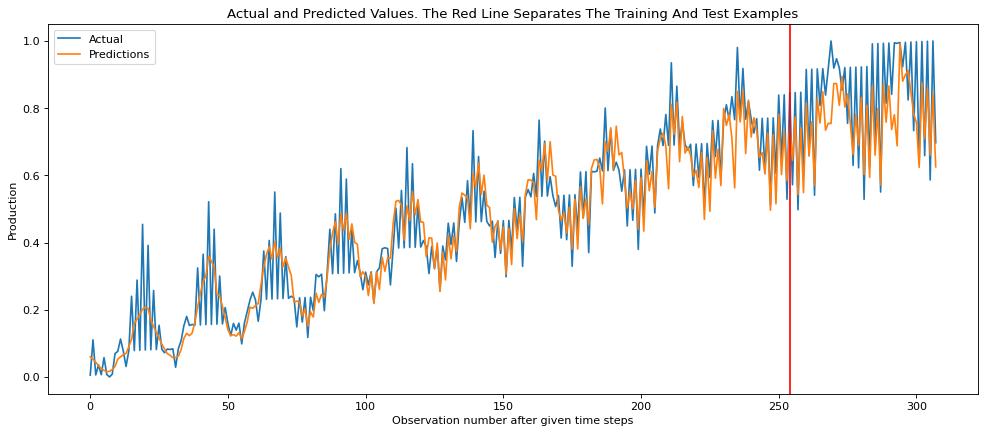

In [ ]:
time_steps = 12
forecast_steps = 3
train_data, test_data, data = get_train_test()
trainX, trainY = get_XY(train_data, time_steps, forecast_steps)
testX, testY = get_XY(test_data, time_steps, forecast_steps)

# Create model and train
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(LSTM(200, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainY, epochs=100, batch_size=4, verbose=2)

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)

#Plot result
plot_result(trainY, testY, train_predict, test_predict)

### Análisis IPSA 1989 a la Fecha


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from sklearn.metrics import roc_curve, auc, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
# Cargar archivo
from google.colab import files
import io
# Cargar archivo desde la máquina local
uploaded2 = files.upload()

# Leer el archivo cargado
file_path = list(uploaded2.keys())[0]
data = pd.read_excel(io.BytesIO(uploaded2[file_path]), sheet_name='Cuadro')

Saving IPSA 1989-2024 Banco Central.xlsx to IPSA 1989-2024 Banco Central.xlsx


In [5]:
data_cleaned = data.iloc[2:].reset_index(drop=True)
data_cleaned.columns = ['Periodo', 'IPSA']
data_cleaned = data_cleaned[['Periodo', 'IPSA']]
data_cleaned['Periodo'] = pd.to_datetime(data_cleaned['Periodo'], errors='coerce')
data_cleaned['IPSA'] = pd.to_numeric(data_cleaned['IPSA'], errors='coerce')

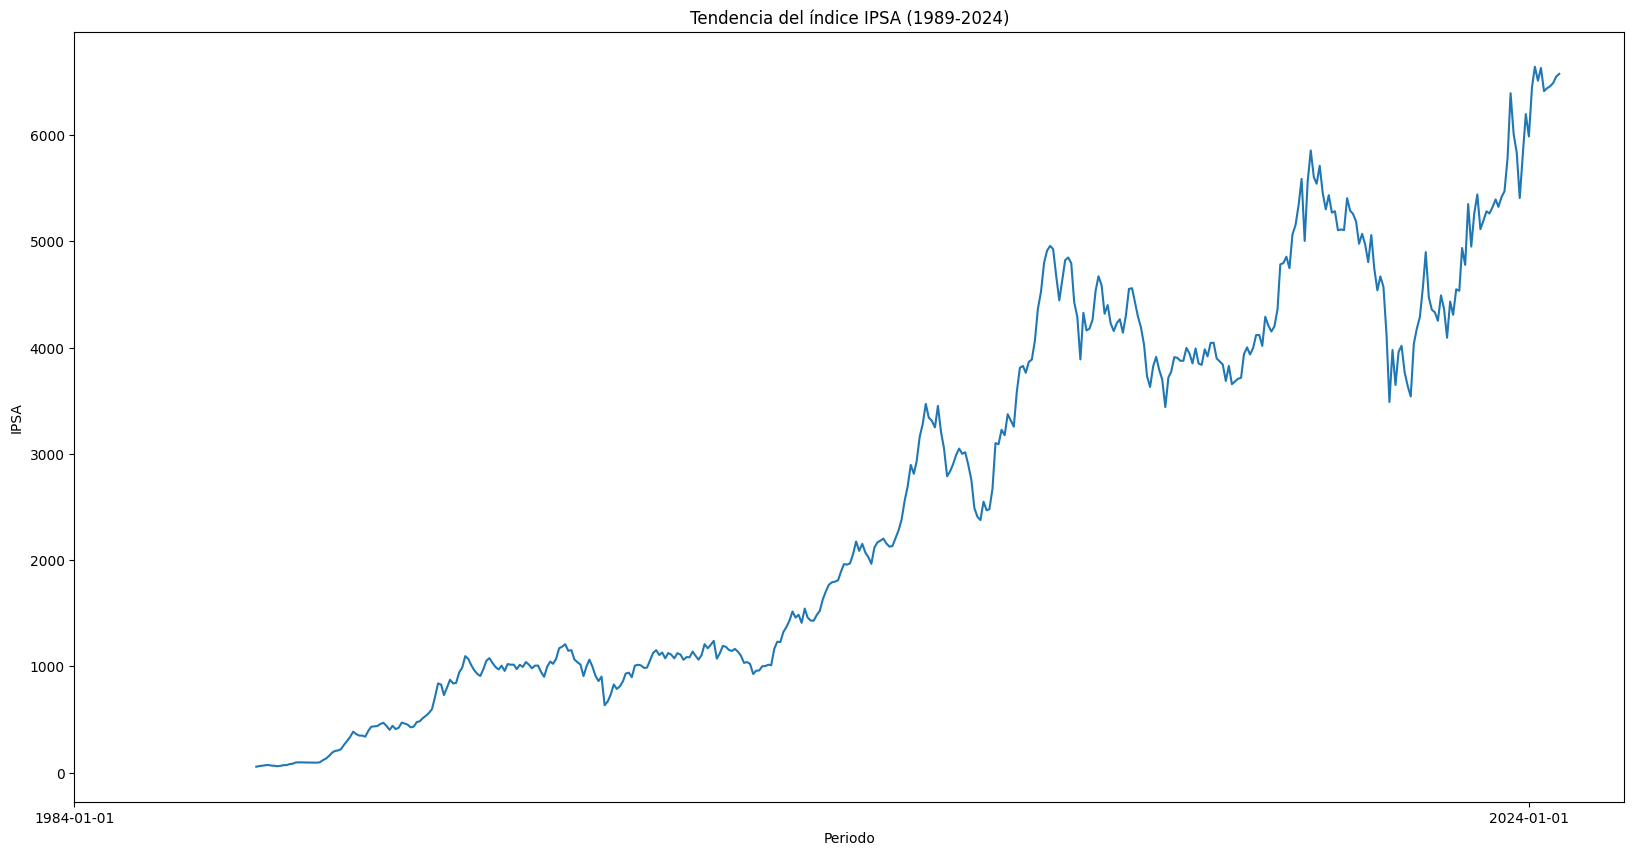

In [6]:
# Gráfico EDA: Tendencia del IPSA a lo largo del tiempo
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=data_cleaned, x='Periodo', y='IPSA')
plt.title('Tendencia del índice IPSA (1989-2024)')
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

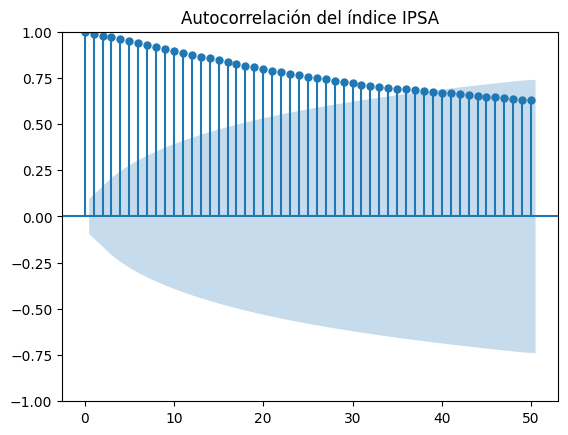

In [7]:
# Gráfico EDA: Autocorrelación del IPSA
plot_acf(data_cleaned['IPSA'], lags=50, title='Autocorrelación del índice IPSA', alpha=0.05)
plt.show()

In [8]:

# Normalización de los valores del IPSA
scaler = MinMaxScaler(feature_range=(0, 1))
data_cleaned['IPSA_normalized'] = scaler.fit_transform(data_cleaned[['IPSA']])

# Crear ventanas de tiempo para LSTM
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 30

In [9]:

data_values = data_cleaned['IPSA_normalized'].values
X, y = create_sequences(data_values, sequence_length)

# Dividir en conjuntos de entrenamiento y prueba
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Añadir una tercera dimensión a los datos de entrada
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construcción del modelo Bidirectional LSTM
model = Sequential([
    Bidirectional(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluación del modelo
loss = model.evaluate(X_test, y_test)
print(f"Loss en el conjunto de prueba: {loss}")

# Predicciones
predictions = model.predict(X_test)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0851 - val_loss: 0.0138
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0107 - val_loss: 0.0403
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0087 - val_loss: 0.0054
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0064 - val_loss: 0.0104
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0029 - val_loss: 0.0053
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030 - val_loss: 0.0040
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049
Loss en el conjunto de prueba: 0.003954850137233734
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


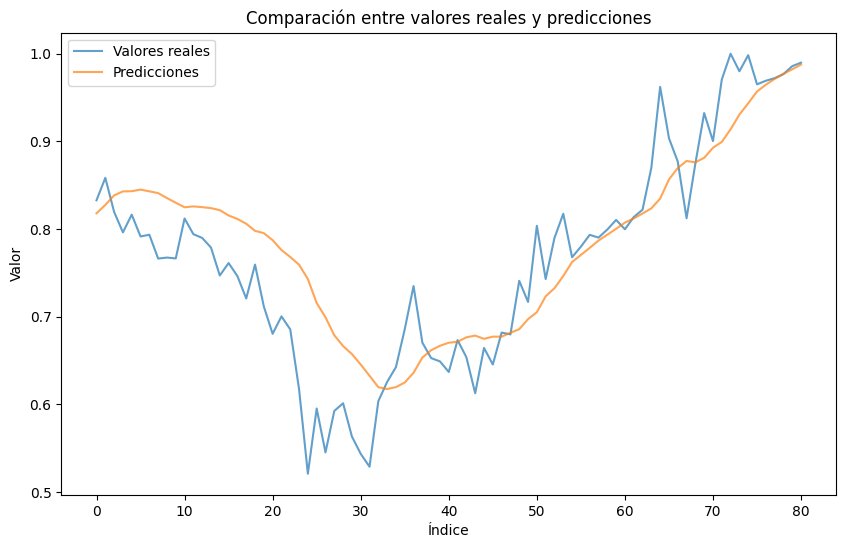

In [11]:

# Comparación de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores reales', alpha=0.7)
plt.plot(predictions, label='Predicciones', alpha=0.7)
plt.title('Comparación entre valores reales y predicciones')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Resultados Futuros:


<ipython-input-12-760ae38307e3>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=data_cleaned['Periodo'].iloc[-1], periods=4, freq='M')[1:]


,Periodo,1.IPSA (índice enero 2003=1000)
0,2024-12-31,6562.196777
1,2025-01-31,6593.517090
2,2025-02-28,6623.586914


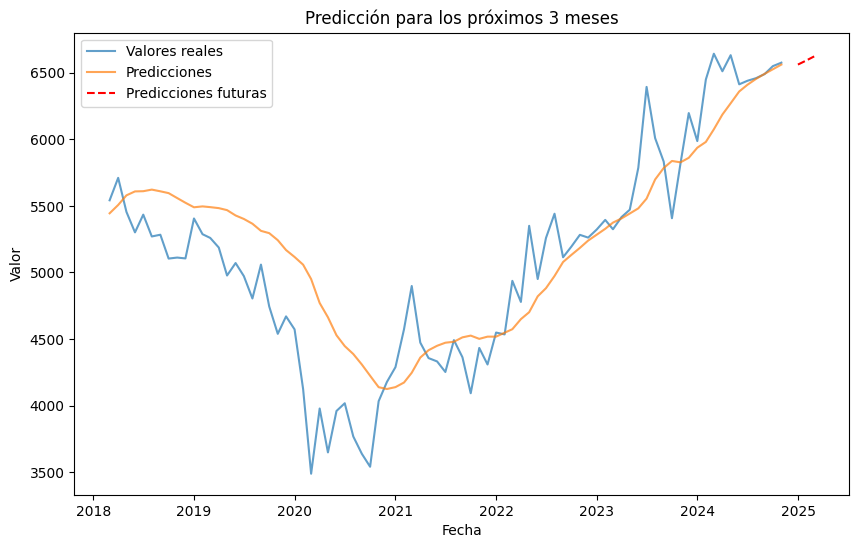

In [12]:

# Predicción de los próximos 3 meses
last_sequence = X_test[-1].reshape(1, sequence_length, 1)
future_predictions = []
for _ in range(3):
    next_prediction = model.predict(last_sequence)[0, 0]
    future_predictions.append(next_prediction)
    next_input = np.append(last_sequence[:, 1:, :], np.expand_dims([[next_prediction]], axis=2), axis=1)
    last_sequence = next_input

# Inversa de la normalización para los valores futuros
future_predictions_real = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Crear un DataFrame para los resultados futuros
future_dates = pd.date_range(start=data_cleaned['Periodo'].iloc[-1], periods=4, freq='M')[1:]
future_results = pd.DataFrame({
    'Periodo': future_dates,
    '1.IPSA (índice enero 2003=1000)': future_predictions_real
})

# Mostrar valores futuros
from IPython.display import display
print("Resultados Futuros:")
display(future_results)

# Crear un gráfico para visualizar las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(data_cleaned['Periodo'].iloc[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Valores reales', alpha=0.7)
plt.plot(data_cleaned['Periodo'].iloc[-len(y_test):], scaler.inverse_transform(predictions.reshape(-1, 1)), label='Predicciones', alpha=0.7)
plt.plot(future_dates, future_predictions_real, label='Predicciones futuras', linestyle='--', color='red')
plt.title('Predicción para los próximos 3 meses')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

# Guardar resultados
results = pd.DataFrame({
    'Fecha': data_cleaned['Periodo'].iloc[sequence_length + split:sequence_length + split + len(y_test)].values,
    'Real': scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(),
    'Predicción': scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
})

## Análisis de resultados

## Conclusiones